# Planar Quadrotor

In this notebook, I explore trajectory generation for a planar quadrotor and then try tracking that trajectory using a Linear Quadratic Regulator (LQR). 

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import control.flatsys as fs
import control as ct
from sympy import UnevaluatedExpr
sympy.init_printing()

## Model Background

Below are the equations for a planar quadrotor. The states include position $x$, $y$, $\theta$ as well their derivatives. The inputs are the forces generated by the two rotors, namely $F_1$ and $F_2$. The quadrotor has a mass $m$ and an inertia $I$ about its center of mass.

\begin{align}
    m \ddot{x} & = - (F_1 + F_2) \sin(\theta) \\
    m \ddot{y} & = (F_1 + F_2) \cos(\theta) - m g \\
    I \ddot{\theta} & = r (F_1 - F_2) \\
\end{align}

Below is an image of the quadrotor.

<center>
    <img src="PlanarQuadrotorDiagram.png" width=450 />
</center>

Putting it all together, below is our state and state derivative.

\begin{equation}
    \mathbf{x} = \begin{bmatrix} x \\ y \\ \theta \\  \dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix}
\end{equation}

\begin{equation}
    \dot{\mathbf{x}} = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \\  \ddot{x} \\ \ddot{y} \\ \ddot{\theta} \end{bmatrix}
    = \begin{bmatrix} \dot{x} \\ \dot{y} \\ \dot{\theta} \\  - \frac{(F_1 + F_2)}{m} \sin(\theta) \\ \frac{(F_1 + F_2)}{m} \cos(\theta) - g \\ \frac{r}{I} (F_1 - F_2) \end{bmatrix}
\end{equation}

I define this model using `sympy`.

In [2]:
x = sympy.symbols('x', cls=sympy.Function)
y = sympy.symbols('y', cls=sympy.Function)
theta = sympy.symbols('theta', cls=sympy.Function)

g = sympy.symbols('g') # gravity
m = sympy.symbols('m')
t = sympy.symbols('t')
F1 = sympy.symbols('F_1')
F2 = sympy.symbols('F_2')
I = sympy.symbols('I') # inertia
r = sympy.symbols('r')

eq1 = sympy.Eq(m * x(t).diff(t,2), - ( F1 + F2) * sympy.sin(theta(t)))
eq2 = sympy.Eq(m * y(t).diff(t,2), ( F1 + F2) * sympy.cos(theta(t)) - m * g)
eq3 = sympy.Eq(I * theta(t).diff(t,2), r * (F1 - F2))

# Trajectory Generation Using Differential Flatness Concept

In this section, I play around with trajectory generation. While I can create an arbitrary trajectory for my planar quadrotor to follow, it may not be dynamically feasible. 

What is a "dynamically feasible" trajectory? By this, I mean that given the dynamics of the robot, it can follow this trajectory. Take a car for instance. If you want to parallel park your car, your car cannot simply move laterally and slide left or right into your desired  parking spot. Given a car with only steered front wheels, you need a series of maneuvers, backing in while turning the steering wheel, moving backwards while turning the wheel in the opposite direction and then straightening the car out.

Differential flatness is a property of a system which you can take advantage of for generating dynamically feasible trajectories. A kinematic bicycle model of a car as well as a planar quadrotor is differentially flat. For those interested in the car example, I suggest reading the [example on Python Controls website](https://python-control.readthedocs.io/en/0.9.4/kincar-flatsys.html). A 3d quadrotor is also differentially flat ([see this](https://www.dropbox.com/scl/fi/1opbxcp3ckzjzcuo0r30h/Lecture3.pdf?rlkey=dpynhrbj24zlphe9z64n1017c&e=1&dl=0)).

### Differential Flatness

A more mathematical definition of differential flatness: 

Assume you have a system with state $x \in \mathcal{R}^n$ and inputs $u \in \mathcal{R}^m$. 

The system is differentially flat if there exists some output (which we call the flat output) $z \in \mathcal{R}^m$ such that 

\begin{equation}
    z = h( x , u, \dot{u}, \ddot{u}, ... , u^{(a)})
\end{equation}

with a mapping to get from the flat outputs to the states and inputs.

\begin{equation}
    x = \alpha(z, \dot{z}, \ddot{z}, ... , z^{(c)})
\end{equation}

\begin{equation}
    u = \beta(z, \dot{z}, \ddot{z}, ... , z^{(c)})
\end{equation}

Note that the dimension of flat outputs is always the same as the dimension of the inputs in the original system.

The reason this mapping is useful is that we can create trajectories in terms of the flat output and then map that trajectory to the input states and inputs in the original system. This ensures a feasible trajectory for the original system.

In this example, I use Python Control's differential flatness functions. I essentially implement functions for the mapping both forwards and backwards. Thne I can pass it into their functions to generate a trajectory.

### Differential Flatness for Planar Quadrotor

For this problem, we can make the flat outputs $x$ and $y$ and our inputs are $u_1$ and $u_2$. So below we have our $h$ function.

\begin{equation}
    z = \begin{bmatrix} x \\ y \end{bmatrix}
\end{equation}

Note that you can't make $\theta$ an output. For more, see [this video](https://www.youtube.com/watch?v=ohBJ0BCtZWQ).

We can solve for the flat outputs given our state. We can also solve for the 3rd and 4th derivative of our flat outputs given our states. 

\begin{equation}
    \dot{z} = \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix}
\end{equation}

\begin{equation}
    \ddot{z} = \begin{bmatrix} \ddot{x} \\ \ddot{y} \end{bmatrix}
    = \begin{bmatrix} - \frac{(F_1 + F_2)}{m} \sin(\theta) \\ \frac{(F_1 + F_2)}{m} \cos(\theta) - g \end{bmatrix}
\end{equation}

\begin{equation}
    \dddot{z} = \begin{bmatrix} \dddot{x} \\ \dddot{y} \end{bmatrix}
    = \begin{bmatrix} \frac{(F_1 + F_2)}{m} \cos(\theta) \dot{\theta} \\
    - \frac{(F_1 + F_2)}{m} \sin(\theta) \dot{\theta} \end{bmatrix}
\end{equation}

\begin{equation}
    z^{(4)} = \begin{bmatrix} x^{(4)} \\ y^{(4)} \end{bmatrix}
    = \begin{bmatrix} \frac{(F_1 + F_2)}{m} \big( -\sin(\theta) \dot{\theta} + \ddot{\theta} \cos(\theta) \big) \\
     - \frac{(F_1 + F_2)}{m} \big( \cos(\theta) \dot{\theta} + \ddot{\theta} \sin(\theta) \big) \end{bmatrix}
\end{equation}

Going in reverse, given our flat ouput, we can solve for our state and our inputs. In order words, we will find the $\alpha$ and $\beta$ mapping. Finding x and y along with their derivaatives is straightforward. 

\begin{align}
    x & = z_1 \\
    y & = z_2 \\
    \dot{x} & = \dot{z}_1 \\
    \dot{y} & = \dot{z}_2 \\
\end{align}

To get $\theta$, we can use the dynamics equations to solve for $\theta$ and then substitute in $\dot{z}_1$ and $\ddot{z_2}$.

\begin{equation}
    \theta = (\frac{-\ddot{z_1}}{\ddot{z_2} + g})
\end{equation}

Then we can use `sympy` to solve for the derivative of $\theta$ based on equation above.

Lastly, how do we solve for the inputs to find the $\beta$ mapping? We can combine the dynamics equations to solve for $u_1$ and $u_2$. However, to do so, we need to know $\ddot{\theta}$. We can get this by taking the equation for $\dot{\theta}$, then taking the derivative. The math gets a bit messy here so I will show the results in `sympy`. You will see that the $\ddot{\theta}$ is a function of the third and fourth derivatives of $x$ and $y$. 

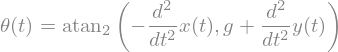

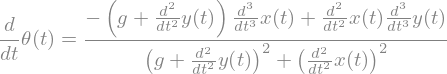

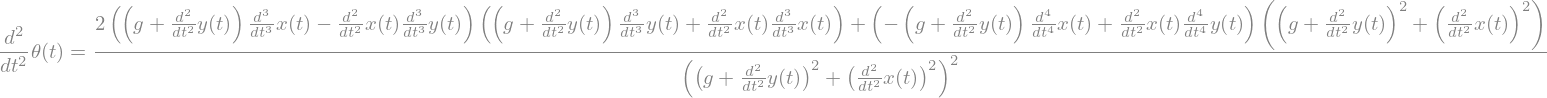

In [3]:
theta_expr = sympy.atan2(-x(t).diff(t,2), y(t).diff(t,2) + g)
theta_dot = sympy.diff(theta_expr,t)
theta_ddot = sympy.diff(theta_dot,t)

# Display our equations
display(sympy.Eq(theta(t), theta_expr))
display(sympy.Eq(theta(t).diff(t),sympy.simplify(theta_dot)))
display(sympy.Eq(theta(t).diff(t,2), sympy.simplify(theta_ddot)))

# Convert into functions that we can use later on
calc_theta_dot = sympy.lambdify([g, x(t).diff(t,2), x(t).diff(t,3), y(t).diff(t,2), y(t).diff(t,3)], sympy.simplify(theta_dot))
calc_theta_ddot = sympy.lambdify([g, x(t).diff(t,2), x(t).diff(t,3), x(t).diff(t,4), y(t).diff(t,2), y(t).diff(t,3), y(t).diff(t,4)], theta_ddot)

Now we can call those functions we created using `lambdify` in the planar quadrotor forward and backward functions.

I have read some sources which say that having this flat output on the body is not necesarily the best and won't work well in some trajectories. I'm curious to try that out in the future. For now though, I will stick with the flat output on the body.

In [4]:
def planar_quadrotor_flat_forward(x, u, params={}):
    # Get the parameter values
    J = params.get('inertia', 0.1425)
    m = params.get('mass', 6.)
    r = params.get('r', 0.25)
    g = params.get('g', 9.81)

    # Create a list of arrays to store the flat output and its derivatives
    zflag = [np.zeros(5), np.zeros(5)]

    # Flat output
    zflag[0][0] = x[0]
    zflag[1][0] = x[1]

    # First derivatives of the flat output
    zflag[0][1] = x[3]
    zflag[1][1] = x[4]

    # Second derivatives of the flat output
    zflag[0][2] = (- 1/ m) * (u[0] + u[1]) * np.sin(x[2])
    zflag[1][2] = (1/ m) * (u[0] + u[1]) * np.cos(x[2]) - g

    theta = x[2]
    
    # theta ddot requires just inputs u 
    theta_ddot = (r / I) * (u[0] - u[1])

    # similar to vehicle example assume du/dt = 0
    
    # Third Derivatives of X and Y
    # should need a theta dot
    zflag[0][3] = ((u[0] + u[1]) / m) * np.cos(theta) * x[5] 
    zflag[1][3] = (- 1 * (u[0] + u[1]) / m) * np.sin(theta) * x[5]

    # Fourth Derivative of X and Y
    # might need a theta ddot which we have
    zflag[0][4] = (u[0] + u[1]) / m * (- np.sin(theta) * x[5] + theta_ddot * np.cos(theta))
    zflag[1][4] = - (u[0] + u[1]) / m * ( np.cos(theta) * x[5] + theta_ddot * np.sin(theta))

    return zflag

def planar_quadrotor_flat_reverse(zflag, params={}):
    # Get the parameter values
    J = params.get('inertia', 0.1425)
    m = params.get('mass', 6.)
    r = params.get('r', 0.25)
    g = params.get('g', 9.81)

    # Create a vector to store the state and inputs
    x = np.zeros(6)
    u = np.zeros(2)

    # Given the flat variables, solve for the state
    # Solve for theta
    theta = np.arctan2(- zflag[0][2], zflag[1][2] + g)

    theta_dot = calc_theta_dot(g, zflag[0][2], zflag[0][3], zflag[1][2], zflag[1][3])
    ddot_theta = calc_theta_ddot(g, zflag[0][2], zflag[0][3], zflag[0][4], zflag[1][2], zflag[1][3], zflag[1][4])
    
    # Solve for original x and y
    x[0] = zflag[0][0]
    x[1] = zflag[1][0]
    x[2] = theta
    x[3] = zflag[0][1]
    x[4] = zflag[1][1]
    x[5] = theta_dot

    # Solve for ddot x and ddot y 
    ddot_x = zflag[0][2]
    ddot_y = zflag[1][2]
    
    # And next solve for the inputs
    u[0] = 0.5 * (m * ddot_y + m * g) / np.cos(theta) + J * ddot_theta / r
    u[1] = u[0] - J * ddot_theta / r

    return x, u

planar_quadrotor_flat = fs.flatsys(
    planar_quadrotor_flat_forward, planar_quadrotor_flat_reverse,
    inputs=('F1', 'F2'), outputs=('x', 'y'), states=('x', 'y', 'theta', 'x_dot', 'y_dot', 'theta_dot'))

### Point to Point 

One method to generate a trajectory is the point to point method. Here we define the start and end points of the trajectory and then utilize the Python `control` library to create the trajectory. Underneath the hood, the library is creating a set of basis functions $\lambda(t)$ to define the trajectory in the flat output space. 

\begin{equation}
    z(t) = A \lambda(t)
\end{equation}

$A$ is a matrix with constant coefficients and is directly computed by the library. Then the library will give us the trajectory in terms of the original system.

Text(0.5, 0, 'Time (sec)')

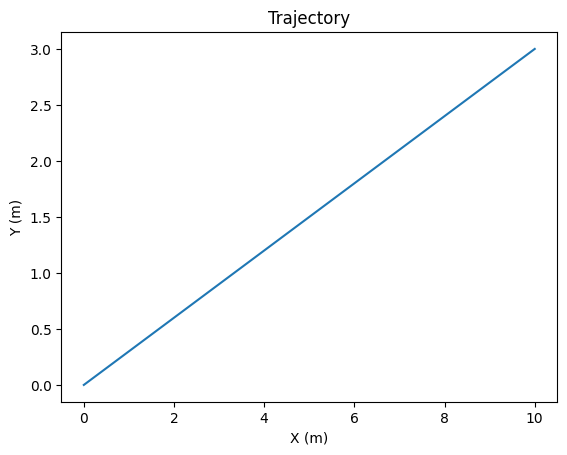

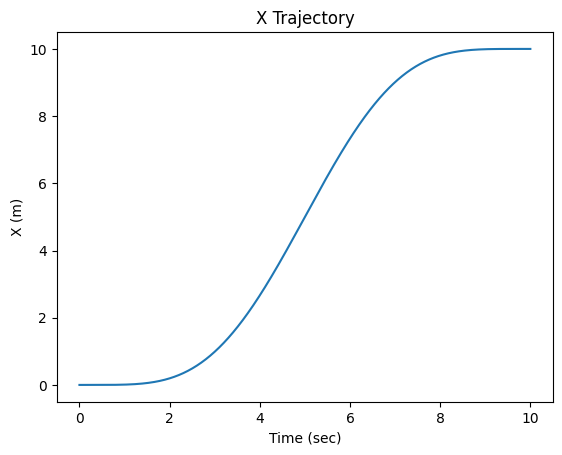

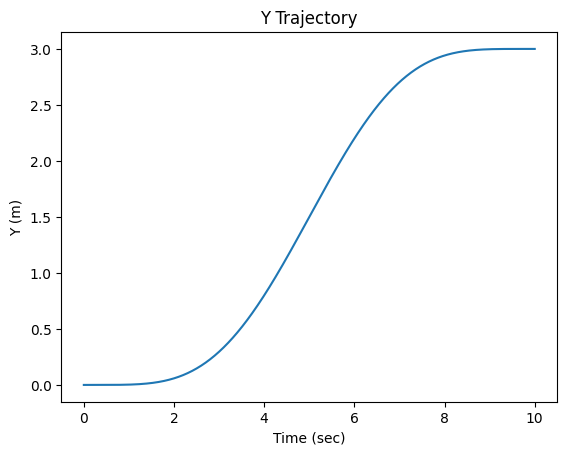

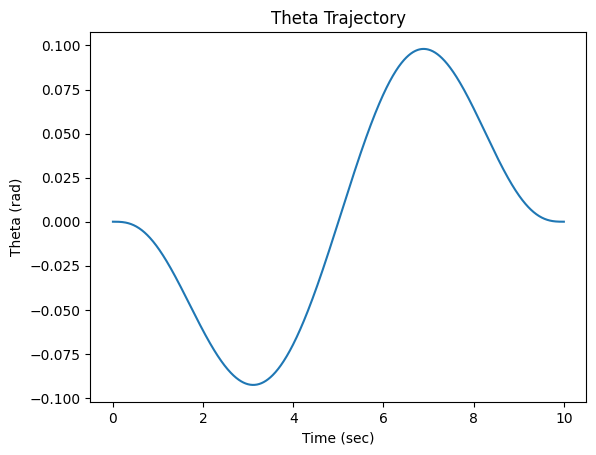

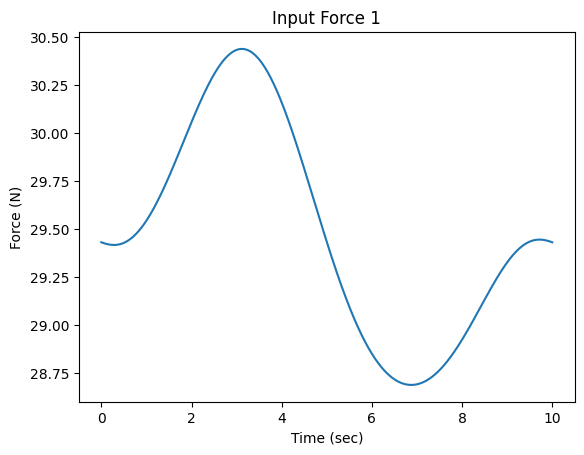

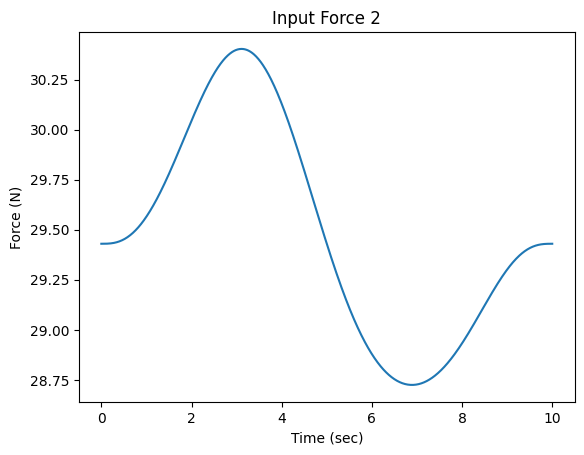

In [5]:
# Define the endpoints of the trajectory
x0 = [0., 0., 0., 0., 0., 0.]; u0 = [29.43, 29.43]
xf = [10., 3., 0., 0., 0., 0.]; uf = [29.43, 29.43]
Tf = 10

# Define a set of basis functions to use for the trajectories
poly = fs.PolyFamily(10)

# Find a trajectory between the initial condition and the final condition
traj = fs.point_to_point(planar_quadrotor_flat, Tf, x0, u0, xf, uf, basis=poly)

# Create the trajectory
timepoints = np.linspace(0, Tf, 1000)
trajectory_data, trajectory_expect_input = traj.eval(timepoints)

plt.figure()
plt.plot(trajectory_data[0, :],trajectory_data[1,:]) 
plt.title('Trajectory')
plt.ylabel('Y (m)')
plt.xlabel('X (m)')

plt.figure()
plt.plot(timepoints,(trajectory_data[0,:]))
plt.title('X Trajectory')
plt.ylabel('X (m)')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(timepoints,(trajectory_data[1,:]))
plt.title('Y Trajectory')
plt.ylabel('Y (m)')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(timepoints,(trajectory_data[2,:]))
plt.title('Theta Trajectory')
plt.ylabel('Theta (rad)')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(timepoints,(trajectory_expect_input[0,:]))
plt.title('Input Force 1')
plt.ylabel('Force (N)')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(timepoints,(trajectory_expect_input[1,:]))
plt.title('Input Force 2')
plt.ylabel('Force (N)')
plt.xlabel('Time (sec)')

Looking at our trajectories, the output makes sense intuitively. If the quadrotor wants to travel in the positive $X$ direction, it needs to first have a negative theta. The input forces are each around the half the weight of the planar quadrotor to support it during flight, as expected.

Note that you can also generate a trajectory via optimal control problem, allowing you to weight certain states and penalize certain behaviors. I don't show that in this example but the Python `control` library offers a good example of how to acheive this.

# Tracking Our Trajectory using Linear Quadratic Regulator (LQR)

In order to track this traajectory, I apply infinite horizon LQR, where the system is linearized about the hover state.

When the quadrotor is hovering, the system is at it's equilibrium point. Recall that the equilibrium point is when the derivatives of the system are equal to 0. During hover, $\theta$ is 0 and and the input forces are each equal to half the weight of the quadrotor.

\begin{equation}
    \theta^* = 0
\end{equation}

\begin{equation}
    u^* = \frac{1}{2} m g
\end{equation}

Below I use `sympy` to calculate the Jacobian of the quadrotor.

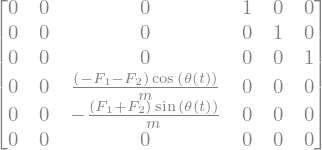

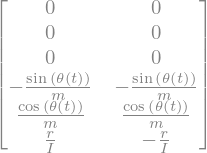

In [6]:
params = {g: 9.81, r: 0.25, m: 6, I: 0.1425}
timestep = 0.01

system = sympy.Matrix([
[x(t).diff(t)],
[y(t).diff(t)],
[theta(t).diff(t)],
[ - ( F1 + F2)/ m * sympy.sin(theta(t))],
[( F1 + F2) /m* sympy.cos(theta(t)) - g],
[ r / I * (F1 - F2)]])

state = sympy.Matrix([
[x(t)],
[y(t)],
[theta(t)],
[x(t).diff(t)],
[y(t).diff(t)],
[theta(t).diff(t)]])


calculate_x_dot = sympy.lambdify([state, F1, F2], system.subs(params))

A_expression = system.jacobian([x(t), y(t), theta(t), x(t).diff(t), y(t).diff(t), theta(t).diff(t)])
B_expression = system.jacobian([F1, F2])

display(A_expression)
display(B_expression)

Now we will evaluate the Jacobian at the equilibrium points. We can do this with the `subs` function. 

We can also use `lambdify` to get our A and B matrices as numpy array.

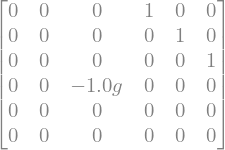

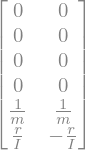

In [7]:
A_expression_at_eq_pt = A_expression.subs([(F1, 0.5 * m * g), (F2, 0.5 * m * g), (theta(t), 0.)])
B_expression_at_eq_pt = B_expression.subs([(F1, 0.5 * m * g), (F2, 0.5 * m * g), (theta(t), 0.)])

display(A_expression_at_eq_pt)
display(B_expression_at_eq_pt)

calculate_A = sympy.lambdify([], A_expression_at_eq_pt.subs(params))
calculate_B = sympy.lambdify([], B_expression_at_eq_pt.subs(params))

Next, we use the python `control` library to create a state space system object, discretize it, and then generate the LQR gains 

In [8]:
C = np.identity(6)
D = np.zeros((6,2))
continuous_sys = ct.StateSpace(calculate_A(), calculate_B(), C, D)
discrete_sys = ct.c2d(continuous_sys, timestep)

# Calculate gains
Q = np.diag([1, 1, 1, 0, 0, 0])
R = np.diag([0.001, 0.001])
K, S, E = ct.dlqr(discrete_sys, Q, R)

# Simulate Closed Loop Control 

Up next, I simulate the LQR controller and the nonlinear plant. I use the Euler discretization to integrate the plant. In the future, I may change this to use RK4. 

There are two points to note about this. Since I'm using the difference between reference and state as the state for the LQR, I'm using `K`, not `-K` for this.

Also, note how in the linearized systems, we ignore the $mg$ term in the second state equation. In order to compensate for this, I add a $\frac{1}{2}mg$ to each input force calculated by the LQR.

In [9]:
nsim = len(timepoints)

x_k = np.array(x0).reshape(6,1)

lqr_tracking_data = np.zeros((nsim, 6))
lqr_control_input = np.zeros((nsim, 2))

for i in range(nsim):
    # Run Controller
    ref = trajectory_data[:,i].reshape(6,1)
    u = K @ (ref - x_k)
    u = u +  np.array([[0.5 * 6* 9.81 / np.cos(x_k[2,0])], [0.5 * 6* 9.81 / np.cos(x_k[2,0])] ])
    
    # Apply input to plant and integrate
    xdot = calculate_x_dot(x_k.reshape(6,), u[0,0], u[1,0])
    x_k = xdot * timestep + x_k

    # Save data for plotting later
    lqr_control_input[i,:] = u.T
    lqr_tracking_data[i,:] = x_k.T
    

In the plots below, we can see thaat the LQR does a decent job tracking the trajectory. We do see the control inputs determined by the LQR come pretty close to the expected inputs calculated when generating the trajectory.

Text(0.5, 1.0, 'Input 2 (N)')

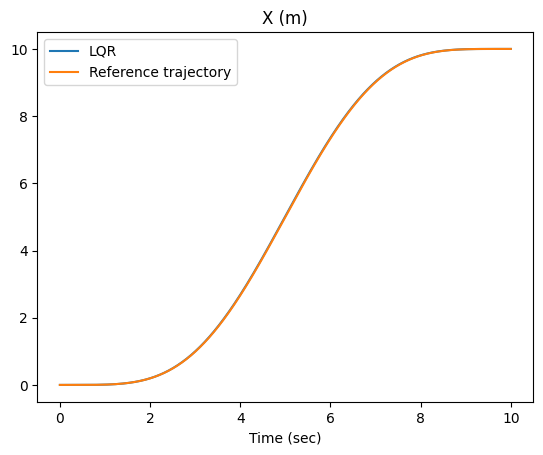

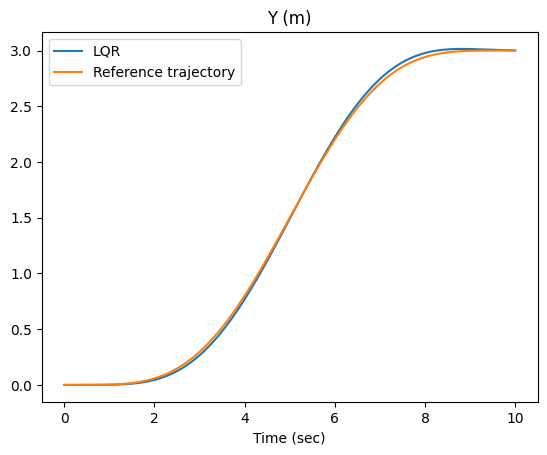

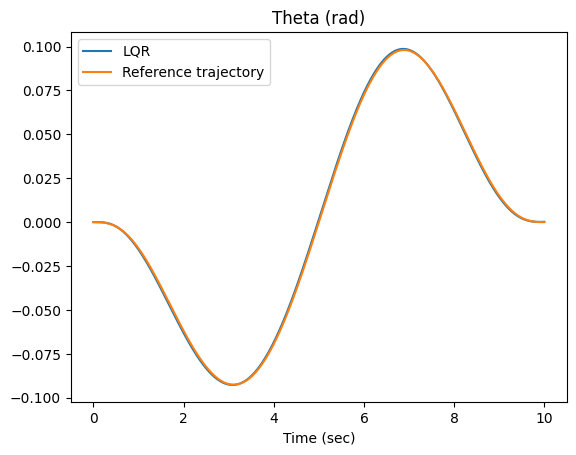

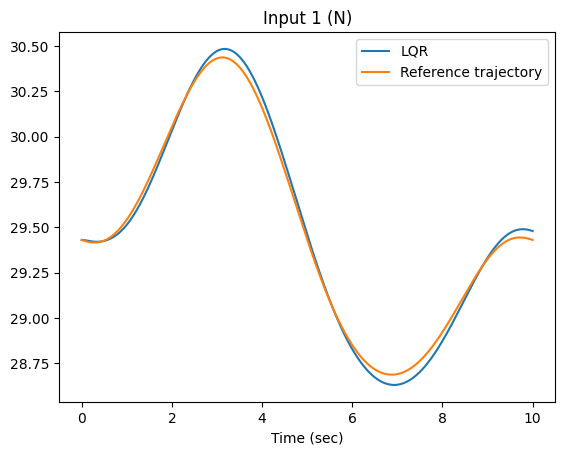

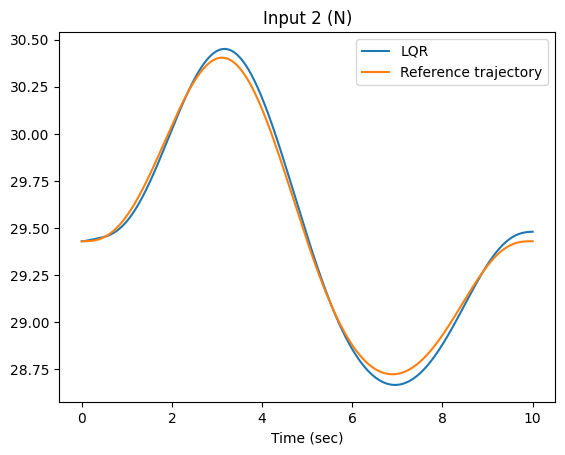

In [11]:
plt.figure()
plt.plot(timepoints, lqr_tracking_data[:, 0], label= 'LQR')
plt.plot(timepoints, trajectory_data[0, :], label='Reference trajectory')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('X (m)')

plt.figure()
plt.plot(timepoints, lqr_tracking_data[:, 1], label= 'LQR')
plt.plot(timepoints, trajectory_data[1, :], label='Reference trajectory')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Y (m)')

plt.figure()
plt.plot(timepoints, lqr_tracking_data[:, 2], label= 'LQR')
plt.plot(timepoints, trajectory_data[2, :], label='Reference trajectory')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Theta (rad)')

plt.figure()
plt.plot(timepoints, lqr_control_input[:, 0], label= 'LQR')
plt.plot(timepoints,(trajectory_expect_input[0,:]), label='Reference trajectory')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Input 1 (N)')

plt.figure()
plt.plot(timepoints, lqr_control_input[:, 1], label= 'LQR')
plt.plot(timepoints,(trajectory_expect_input[1,:]), label='Reference trajectory')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Input 2 (N)')

## References

1. [Python Control Library Differential Flatness Example](https://python-control.readthedocs.io/en/0.10.1/kincar-flatsys.html)
    - The library provides example code applying differential flatness to a kinematic car model. I take the same concept but apply it to a different model, a planar quadrotor.
2. [Underactuated Robotics](https://underactuated.mit.edu/acrobot.html)
3. [Introduction to Robotics](https://irom-lab.princeton.edu/intro-to-robotics/) from Majumdar along with their corresponding [Notes](https://www.dropbox.com/scl/fi/i1glazx35mdomyqosf8pa/Lecture9_notes.pdf?rlkey=61wex0dcq793m977wv5n3m7tc&e=1&dl=0)